# DATASET CREATION

In [1]:
%%capture
!pip install allensdk

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from pprint import pprint # pretty print

import os
from tqdm import tqdm  

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
# la classe BrainObservatoryCache serve a scaricare dataset neuroscientifici dall’Allen Institute, reparto Osservazioni di Cervelli

In [3]:
boc = BrainObservatoryCache() # creiamo un'istanza della classe

# recuperiamo i container tramite gli id che ci sono stati suggeriti
sessions = boc.get_ophys_experiments(
    experiment_container_ids=[511507650,511510667,511510675,511510699,511510718,511510779,511510855,511510989,526481129],
    require_eye_tracking=True,
    include_failed=False,
    session_types=['three_session_A']
)

pprint(len(sessions))

6


* Provvediamo alla ricerca di un esperimento (una sessione) tra le sessioni di tipo A estrapolate dalla lista di container data in input.
* Nello specifico, vogliamo selezionarne uno dove sono disponibili i dati per il tracciamento degli occhi dei topi.

In [104]:
session_data = None
for session in sessions:
    try:
        session_id = session['id']
        session_data = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)
        session_data.get_pupil_size()
        print(f"trovata sessione dove funziona il reperimento della pupil_size: {session_id}")
        session_data.get_pupil_location()
        print(f"trovata sessione dove funziona il reperimento della pupil_location: {session_id}")
        break
    except:
        continue

2025-07-18 08:35:15,602 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516803202
2025-07-18 08:35:41,528 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516802477
2025-07-18 08:36:12,167 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/527313362


trovata sessione dove funziona il reperimento della pupil_size: 501729039
trovata sessione dove funziona il reperimento della pupil_location: 501729039


### Dopo una prima esecuzione della cella soprastante, abbiamo ottenuto un session_id = 501729039 (Per Sessione A) 


In [4]:
session_data = boc.get_ophys_experiment_data(ophys_experiment_id=501729039)

2025-07-18 13:34:20,197 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516804316


In [5]:
# mostriamo gli stimoli nella loro sequenza 
print(session_data.get_stimulus_epoch_table())

              stimulus  start     end
0    drifting_gratings    735   18806
1  natural_movie_three  19741   37846
2    natural_movie_one  38751   47810
3    drifting_gratings  48716   66786
4          spontaneous  66936   75866
5  natural_movie_three  75867   93967
6    drifting_gratings  94873  115478


In [6]:
pprint(session_data.get_metadata())
num_neurons = session_data.get_cell_specimen_ids()
print(f"\nnumero nueroni per la sessione: {len(num_neurons)}")

{'age_days': 105,
 'cre_line': 'Rorb-IRES2-Cre/wt',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.1',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 511510989,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Rorb-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'imaging_depth_um': 275,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 501729039,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2016, 2, 5, 13, 55, 40),
 'session_type': 'three_session_A',
 'sex': 'male',
 'specimen_name': 'Rorb-IRES2-Cre;Camk2a-tTA;Ai93-222431',
 'targeted_structure': 'VISp'}

numero nueroni per la sessione: 227


In [7]:
# Ottieniamo il template del video di tipo 'natural_movie_one'
movie_one_template = session_data.get_stimulus_template('natural_movie_one')
print(f"Dimensioni del video 'natural_movie_one': {movie_one_template.shape}")
# Output : (900, 304, 608) <-> (frames, height, width)

# Ottieniamo il template del video di tipo 'natural_movie_three'
movie_three_template = session_data.get_stimulus_template('natural_movie_three')
print(f"Dimensioni del video 'natural_movie_three': {movie_three_template.shape}")
# Output : (3600, 304, 608) <-> (frames, height, width)

Dimensioni del video 'natural_movie_one': (900, 304, 608)
Dimensioni del video 'natural_movie_three': (3600, 304, 608)


In [8]:
# Resizing delle dimensioni spaziali [304, 608] -> [36, 64]
from scipy import ndimage

videos = [movie_one_template, movie_three_template]
target_height = 36
target_width = 64

resized_videos = []
for video in videos:
    resized_frames = []
    for frame in video:
        zoom_factors = (target_height / frame.shape[0], target_width / frame.shape[1])
        new_frame = ndimage.zoom(frame, zoom_factors, order=1)
        resized_frames.append(new_frame)
    
    resized_videos.append(np.array(resized_frames))

pprint(resized_videos[0].shape) # (900, 36, 64)
pprint(resized_videos[1].shape) # (3600, 36, 64)

(900, 36, 64)
(3600, 36, 64)


In [9]:
def segmentation(items,pos_num_frames=0, target_frames=140) -> (list): 
    total_frames = items.shape[pos_num_frames]
    num_items = total_frames // target_frames
    if len(items.shape) == 3: #video -> 3 dimensioni
        return [items[i*target_frames:(i+1)*target_frames, :, :] for i in range(num_items)]
    elif pos_num_frames==1: # resposes (dff) -> 2 dimensioni, ma qui dobbiamo ciclare sulla seconda dimensione
        return [items[:, i*target_frames:(i+1)*target_frames] for i in range(num_items)]
    else:
        return [items[i*target_frames:(i+1)*target_frames, :] for i in range(num_items)]

In [10]:
cropped_one = segmentation(resized_videos[0])
cropped_three = segmentation(resized_videos[1])

print(f"Numero clip in natural_movie_'one': {len(cropped_one)}")
print(f"Numero clip in natural_movie_'three': {len(cropped_three)}")

Numero clip in natural_movie_'one': 6
Numero clip in natural_movie_'three': 25


In [11]:
total_frames = 0
for clip in cropped_one:
    total_frames += clip.shape[0]

print(f"numero di frames totale per quanto riguarda l'intero video di tipo 'one' dopo la segmentazione: {total_frames}")

total_frames = 0
for clip in cropped_three:
    total_frames += clip.shape[0]

print(f"numero di frames totale per quanto riguarda l'intero video di tipo 'three' dopo la segmentazione: {total_frames}")

numero di frames totale per quanto riguarda l'intero video di tipo 'one' dopo la segmentazione: 840
numero di frames totale per quanto riguarda l'intero video di tipo 'three' dopo la segmentazione: 3500


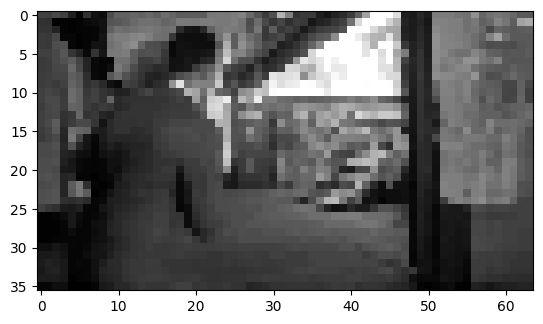

In [12]:
# Mostriamo uno frame del video tipo 'one' manipolato
plt.imshow(cropped_one[0][139], cmap='gray')

In [13]:
def compute_stats(items):
    all_values = np.concatenate([item.astype(np.float32).ravel() for item in items])

    mean = np.mean(all_values)
    std = np.std(all_values)
    min_val = np.min(all_values)
    max_val = np.max(all_values)

    return mean, std, min_val, max_val

In [14]:
def min_max_normalize(items, min_val, max_val, eps=1e-8):
    """
    Applica la normalizzazione elemento per elemento.
    
    Formula: (x - min) / (max - min), con eps per evitare divisioni per zero.
    """
    range_val = max_val - min_val
    range_safe = np.where(range_val > 0, range_val, eps) 

    return [(item - min_val) / range_safe for item in items]

In [15]:
def dff_normalize(items, std):
    return [item / std for item in items]

In [16]:
mean1, std1, min1, max1 = compute_stats(cropped_one)
mean3, std3, min3, max3 = compute_stats(cropped_three)

print("Video One -> Mean:", mean1, "Std:", std1, "Min:", min1, "Max:", max1)
print("Video Three -> Mean:", mean3, "Std:", std3, "Min:", min3, "Max:", max3)

normalized_one = min_max_normalize(cropped_one, min1,max1)
normalized_three = min_max_normalize(cropped_three, min3,max3)

Video One -> Mean: 125.1394 Std: 47.314507 Min: 0.0 Max: 255.0
Video Three -> Mean: 124.52131 Std: 45.1299 Min: 22.0 Max: 255.0


In [17]:
# Pupil_center
timestamps, pupil_location = session_data.get_pupil_location()
print(pupil_location.shape)

(115735, 2)


In [18]:
def filter_data(item, num_item_frames, offset, pos=None):
    filtered_list = []
    for i in range(10):
        start = i * (num_item_frames + offset)
        end = start + num_item_frames
        if pos is not None: # dff => la shape è [num_neuroni, num_frames]
            filtered_list.append(item[:, start:end])
        else:
            filtered_list.append(item[start:end,:])

    if pos is not None:
        return np.concatenate(filtered_list, axis=1)
    
    return np.concatenate(filtered_list, axis=0)

In [19]:
# mostriamo gli stimoli nella loro sequenza 
print(session_data.get_stimulus_epoch_table())

              stimulus  start     end
0    drifting_gratings    735   18806
1  natural_movie_three  19741   37846
2    natural_movie_one  38751   47810
3    drifting_gratings  48716   66786
4          spontaneous  66936   75866
5  natural_movie_three  75867   93967
6    drifting_gratings  94873  115478


In [20]:
pupil_location_one = pupil_location[38751:47810,:]
pupil_location_one = filter_data(pupil_location_one, 840, 66)
print(pupil_location_one.shape)

(8400, 2)


In [21]:
tmp_pupil_location_three = [pupil_location[19741:37846,:], pupil_location[75867:93967,:]]

pupil_location_three = []
pupil_location_three.append(filter_data(tmp_pupil_location_three[0], 3500, 121))
pupil_location_three.append(filter_data(tmp_pupil_location_three[1], 3500, 120))

print(pupil_location_three[0].shape)
print(pupil_location_three[1].shape)

(17500, 2)
(17500, 2)


In [22]:
pupil_location_one_segmented = segmentation(pupil_location_one)
pupil_location_three_segmented = segmentation(pupil_location_three[0])
pupil_location_three_segmented.extend(segmentation(pupil_location_three[1]))

print(len(pupil_location_one_segmented))
print(len(pupil_location_three_segmented))

60
250


In [23]:
pupil_location_one_train = pupil_location_one_segmented[:-12]
pupil_location_one_validation = pupil_location_one_train[-6:] # 1 trial
pupil_location_one_train = pupil_location_one_train[:-6]
pupil_location_one_test = pupil_location_one_segmented[-12:]

pupil_location_three_train = pupil_location_three_segmented[:-50]
pupil_location_three_validation = pupil_location_three_train[-25:] # 1 trial
pupil_location_three_train = pupil_location_three_train[:-25] 
pupil_location_three_test = pupil_location_three_segmented[-50:]

In [24]:
print(f"# elementi pupil_location_one_train: {len(pupil_location_one_train)}")
print(f"# elementi pupil_location_one_validation: {len(pupil_location_one_validation)}")
print(f"# elementi pupil_location_one_test: {len(pupil_location_one_test)}")

print(f"# elementi pupil_location_three_train: {len(pupil_location_three_train)}")
print(f"# elementi pupil_location_three_validation: {len(pupil_location_three_validation)}")
print(f"# elementi pupil_location_three_test: {len(pupil_location_three_test)}")

# elementi pupil_location_one_train: 42
# elementi pupil_location_one_validation: 6
# elementi pupil_location_one_test: 12
# elementi pupil_location_three_train: 175
# elementi pupil_location_three_validation: 25
# elementi pupil_location_three_test: 50


In [25]:
running_speed, _ = session_data.get_running_speed()
_, pupil_size = session_data.get_pupil_size()

behavior = np.column_stack((running_speed, pupil_size))

In [26]:
behavior_one = behavior[38751:47810,:]
behavior_one = filter_data(behavior_one, 840, 66)
print(behavior_one.shape)

(8400, 2)


In [27]:
tmp_behavior_three = [behavior[19741:37846,:], behavior[75867:93967,:]]

behavior_three = []
behavior_three.append(filter_data(tmp_behavior_three[0], 3500, 121))
behavior_three.append(filter_data(tmp_behavior_three[1], 3500, 120))

print(behavior_three[0].shape)
print(behavior_three[1].shape)

(17500, 2)
(17500, 2)


In [28]:
behavior_one_segmented = segmentation(behavior_one)
behavior_three_segmented = segmentation(behavior_three[0])
behavior_three_segmented.extend(segmentation(behavior_three[1]))

print(len(behavior_one_segmented))
print(len(behavior_three_segmented))

60
250


In [29]:
behavior_one_train = behavior_one_segmented[:-12]
behavior_one_validation = behavior_one_train[-6:] # 1 trial
behavior_one_train = behavior_one_train[:-6]
behavior_one_test = behavior_one_segmented[-12:]

behavior_three_train = behavior_three_segmented[:-50]
behavior_three_validation = behavior_three_train[-25:] # 1 trial
behavior_three_train = behavior_three_train[:-25] 
behavior_three_test = behavior_three_segmented[-50:]

In [30]:
print(f"# elementi behavior_one_train: {len(behavior_one_train)}")
print(f"# elementi behavior_one_validation: {len(behavior_one_validation)}")
print(f"# elementi behavior_one_test: {len(behavior_one_test)}")

print(f"# elementi behavior_three_train: {len(behavior_three_train)}")
print(f"# elementi behavior_three_validation: {len(behavior_three_validation)}")
print(f"# elementi behavior_three_test: {len(behavior_three_test)}")

# elementi behavior_one_train: 42
# elementi behavior_one_validation: 6
# elementi behavior_one_test: 12
# elementi behavior_three_train: 175
# elementi behavior_three_validation: 25
# elementi behavior_three_test: 50


In [31]:
# dff
_, dff = session_data.get_dff_traces()
print(dff.shape)

(227, 115735)


In [32]:
dff_one = dff[:, 38751:47810]
dff_one = filter_data(dff_one, 840, 66, "dff")
print(dff_one.shape)

(227, 8400)


In [33]:
tmp_dff_three = [dff[:, 19741:37846,], dff[:, 75867:93967]]

dff_three = []
dff_three.append(filter_data(tmp_dff_three[0], 3500, 121, "dff"))
dff_three.append(filter_data(tmp_dff_three[1], 3500, 120, "dff"))

print(dff_three[0].shape)
print(dff_three[1].shape)

(227, 17500)
(227, 17500)


In [34]:
dff_one_segmented = segmentation(dff_one,1)
dff_three_segmented = segmentation(dff_three[0],1)
dff_three_segmented.extend(segmentation(dff_three[1],1))

print(len(dff_one_segmented))
print(len(dff_three_segmented))

60
250


In [35]:
dff_one_train = dff_one_segmented[:-12]
dff_one_validation = dff_one_train[-6:] # 1 trial
dff_one_train = dff_one_train[:-6]
dff_one_test = dff_one_segmented[-12:]

dff_three_train = dff_three_segmented[:-50]
dff_three_validation = dff_three_train[-25:] # 1 trial
dff_three_train = dff_three_train[:-25]
dff_three_test = dff_three_segmented[-50:]

In [36]:
print(f"# elementi dff_one_train: {len(dff_one_train)}")
print(f"# elementi dff_one_validation: {len(dff_one_validation)}")
print(f"# elementi dff_one_test: {len(dff_one_test)}")

print(f"# elementi dff_three_train: {len(dff_three_train)}")
print(f"# elementi dff_three_validation: {len(dff_three_validation)}")
print(f"# elementi dff_three_test: {len(dff_three_test)}")

# elementi dff_one_train: 42
# elementi dff_one_validation: 6
# elementi dff_one_test: 12
# elementi dff_three_train: 175
# elementi dff_three_validation: 25
# elementi dff_three_test: 50


In [37]:
def fill_missing_values(items,mean = None):
    items = np.array(items)  # Converte in array NumPy (se non lo è già)
    if mean:
         items[items == 0] = mean  
    else:
        items[np.isnan(items)] = 0  # Sostituisce i NaN con il valore medio (tecnica di "data imputation")
    return items

In [38]:
# TRAIN
behavior_one_train = fill_missing_values(behavior_one_train)
behavior_three_train = fill_missing_values(behavior_three_train)

pupil_location_one_train = fill_missing_values(pupil_location_one_train)
pupil_location_three_train = fill_missing_values(pupil_location_three_train)

dff_one_train = fill_missing_values(dff_one_train)
dff_three_train = fill_missing_values(dff_three_train)

# VALIDATION
behavior_one_validation = fill_missing_values(behavior_one_validation)
behavior_three_validation = fill_missing_values(behavior_three_validation)

pupil_location_one_validation = fill_missing_values(pupil_location_one_validation)
pupil_location_three_validation = fill_missing_values(pupil_location_three_validation)

dff_one_validation = fill_missing_values(dff_one_validation)
dff_three_validation = fill_missing_values(dff_three_validation)

# TEST
behavior_one_test = fill_missing_values(behavior_one_test)
behavior_three_test = fill_missing_values(behavior_three_test)

pupil_location_one_test = fill_missing_values(pupil_location_one_test)
pupil_location_three_test = fill_missing_values(pupil_location_three_test)

dff_one_test = fill_missing_values(dff_one_test)
dff_three_test = fill_missing_values(dff_three_test)

In [39]:
def compute_stats(items):
    all_values = np.concatenate([item.astype(np.float32).ravel() for item in items])

    mean = np.mean(all_values)
    std = np.std(all_values)
    min_val = np.min(all_values)
    max_val = np.max(all_values)

    return mean, std, min_val, max_val

In [40]:
# Adesso per fare la data imputations sostituiamo i valori 0 con la media

# Calcolo statistiche per behavior (sia train che validation)
mean_b1_train, _, min_behavior1, max_behavior1 = compute_stats(behavior_one_train)
mean_b3_train, _, min_behavior3, max_behavior3 = compute_stats(behavior_three_train)
mean_b1_val, _, min_behavior1_val, max_behavior1_val = compute_stats(behavior_one_validation)
mean_b3_val, _, min_behavior3_val, max_behavior3_val = compute_stats(behavior_three_validation)


# Calcolo statistiche per pupil_location (sia train che validation)
mean_p1_train, _, min_pupil1, max_pupil1 = compute_stats(pupil_location_one_train)
mean_p3_train, _, min_pupil3, max_pupil3 = compute_stats(pupil_location_three_train)
mean_p1_val, _, min_pupil1_val, max_pupil1_val = compute_stats(pupil_location_one_validation)
mean_p3_val, _, min_pupil3_val, max_pupil3_val = compute_stats(pupil_location_three_validation)


# Calcolo statistiche per dff (sia train che validation)
mean_dff1_train, dff_std1, _, _ = compute_stats(dff_one_train)
mean_dff3_train, dff_std3, _, _ = compute_stats(dff_three_train)
mean_dff1_val, dff_std1_val, _, _ = compute_stats(dff_one_validation)
mean_dff3_val, dff_std3_val, _, _ = compute_stats(dff_three_validation)



# TRAIN
behavior_one_train = fill_missing_values(behavior_one_train,mean_b1_train)
behavior_three_train = fill_missing_values(behavior_three_train, mean_b3_train)

pupil_location_one_train = fill_missing_values(pupil_location_one_train, mean_p1_train)
pupil_location_three_train = fill_missing_values(pupil_location_three_train, mean_p3_train)

dff_one_train = fill_missing_values(dff_one_train, mean_dff1_train)
dff_three_train = fill_missing_values(dff_three_train, mean_dff3_train)

# VALIDATION
behavior_one_validation = fill_missing_values(behavior_one_validation, mean_b1_val)
behavior_three_validation = fill_missing_values(behavior_three_validation, mean_b3_val)

pupil_location_one_validation = fill_missing_values(pupil_location_one_validation, mean_p1_val)
pupil_location_three_validation = fill_missing_values(pupil_location_three_validation, mean_p3_val)

dff_one_validation = fill_missing_values(dff_one_validation, mean_dff1_val)
dff_three_validation = fill_missing_values(dff_three_validation, mean_dff3_val)

# TEST
behavior_one_test = fill_missing_values(behavior_one_test, mean_b1_train)
behavior_three_test = fill_missing_values(behavior_three_test, mean_b3_train)

pupil_location_one_test = fill_missing_values(pupil_location_one_test, mean_p1_train)
pupil_location_three_test = fill_missing_values(pupil_location_three_test, mean_p3_train)

dff_one_test = fill_missing_values(dff_one_test, mean_dff1_train)
dff_three_test = fill_missing_values(dff_three_test, mean_dff3_train)

In [41]:

# Normalizzazione 
normalized_behavior_one = min_max_normalize(behavior_one_train, min_behavior1, max_behavior1)
normalized_behavior_three = min_max_normalize(behavior_three_train, min_behavior3, max_behavior3)
normalized_behavior_one_val = min_max_normalize(behavior_one_validation, min_behavior1_val, max_behavior1_val)
normalized_behavior_three_val = min_max_normalize(behavior_three_validation, min_behavior3_val, max_behavior3_val)



# Normalizzazione
normalized_pupil_location_one = min_max_normalize(pupil_location_one_train, min_pupil1, max_pupil1)
normalized_pupil_location_three = min_max_normalize(pupil_location_three_train, min_pupil3, max_pupil3)
normalized_pupil_location_one_val = min_max_normalize(pupil_location_one_validation, min_pupil1_val, max_pupil1_val)
normalized_pupil_location_three_val = min_max_normalize(pupil_location_three_validation, min_pupil3_val, max_pupil3_val)


# Normalizzazione
normalized_dff_one = dff_normalize(dff_one_train, dff_std1)
normalized_dff_three = dff_normalize(dff_three_train, dff_std3)
normalized_dff_one_val = dff_normalize(dff_one_validation, dff_std1_val)
normalized_dff_three_val = dff_normalize(dff_three_validation, dff_std3_val)

In [42]:
def save_items(items, start_idx, output_dir, label="", trials=1):
    index = start_idx
    total = trials * len(items)
    with tqdm(total=total, desc=f"Saving {label}", unit=label) as pbar:
        for i in range(trials):
            for item in items:
                filename = f"{index}.npy"
                filepath = os.path.join(output_dir, filename)
                np.save(filepath, item)
                index += 1
                pbar.update(1)
    return index

In [43]:
output_dir_videos = '/kaggle/working/train/data/videos'
output_dir_behavior = '/kaggle/working/train/data/behavior'
output_dir_pupil_center = '/kaggle/working/train/data/pupil_center'
output_dir_dff = '/kaggle/working/train/data/labels'

output_dir_videos_val = '/kaggle/working/validation/data/videos'
output_dir_behavior_val = '/kaggle/working/validation/data/behavior'
output_dir_pupil_center_val = '/kaggle/working/validation/data/pupil_center'
output_dir_dff_val = '/kaggle/working/validation/data/labels'

os.makedirs(output_dir_videos, exist_ok=True)
os.makedirs(output_dir_behavior, exist_ok=True)
os.makedirs(output_dir_pupil_center, exist_ok=True)
os.makedirs(output_dir_dff, exist_ok=True)

os.makedirs(output_dir_videos_val, exist_ok=True)
os.makedirs(output_dir_behavior_val, exist_ok=True)
os.makedirs(output_dir_pupil_center_val, exist_ok=True)
os.makedirs(output_dir_dff_val, exist_ok=True)

# Salvataggio TRAINING
next_index = save_items(items=normalized_one, start_idx=0, trials=7, label="normalized_one", output_dir=output_dir_videos)
_ = save_items(items=normalized_three, start_idx=next_index, trials=7, label="normalized_three", output_dir=output_dir_videos)

next_index_behavior = save_items(items=normalized_behavior_one, start_idx=0, output_dir=output_dir_behavior, label="normalized_behavior_one")
_ = save_items(items=normalized_behavior_three, start_idx=next_index_behavior, output_dir=output_dir_behavior, label="normalized_behavior_three")

next_index_pupil_center = save_items(items=normalized_pupil_location_one, start_idx=0, output_dir=output_dir_pupil_center, label="normalized_pupil_location_one")
_ = save_items(items=normalized_pupil_location_three, start_idx=next_index_pupil_center, output_dir=output_dir_pupil_center, label="normalized_pupil_location_three")

next_index_dff = save_items(items=normalized_dff_one, start_idx=0, output_dir=output_dir_dff, label="normalized_dff_one")
_ = save_items(items=normalized_dff_three, start_idx=next_index_dff, output_dir=output_dir_dff, label="normalized_dff_three")

# Salvataggio VALIDATION
next_index_val = save_items(items=normalized_one, start_idx=0, trials=1, label="normalized_one_val", output_dir=output_dir_videos_val)
_ = save_items(items=normalized_three, start_idx=next_index_val, trials=1, label="normalized_three_val", output_dir=output_dir_videos_val)

next_index_behavior_val = save_items(items=normalized_behavior_one_val, start_idx=0, output_dir=output_dir_behavior_val, label="normalized_behavior_one_val")
_ = save_items(items=normalized_behavior_three_val, start_idx=next_index_behavior_val, output_dir=output_dir_behavior_val, label="normalized_behavior_three_val")

next_index_pupil_center_val = save_items(items=normalized_pupil_location_one_val, start_idx=0, output_dir=output_dir_pupil_center_val, label="normalized_pupil_location_one_val")
_ = save_items(items=normalized_pupil_location_three_val, start_idx=next_index_pupil_center_val, output_dir=output_dir_pupil_center_val, label="normalized_pupil_location_three_val")

next_index_dff_val = save_items(items=normalized_dff_one_val, start_idx=0, output_dir=output_dir_dff_val, label="normalized_dff_one_val")
_ = save_items(items=normalized_dff_three_val, start_idx=next_index_dff_val, output_dir=output_dir_dff_val, label="normalized_dff_three_val")

Saving normalized_dff_three_val: 100%|██████████| 25/25 [00:00<00:00, 5123.25normalized_dff_three_val/s]


* recuperiamo i vari pezzi per il test (video, behavior, pupil_center ,responses)
* li normalizziamo sfruttando le statistiche ottenute dal train_set
* infine, li salviamo nelle loro directory

In [44]:
############################### VIDEOS ################################
output_dir = '/kaggle/working/test/data/videos'
os.makedirs(output_dir, exist_ok=True)

# Numero di ripetizioni per ciascun video
trials = 2

# Salvataggio 
next_index = save_items(items=normalized_one, start_idx= 0, trials=trials, label="normalized_one", output_dir=output_dir)
_ = save_items(items=normalized_three, start_idx=next_index, trials=trials, label="normalized_three", output_dir=output_dir)

############################### PUPIL LOCATION ################################
output_dir = '/kaggle/working/test/data/pupil_center'
os.makedirs(output_dir, exist_ok=True)

# Normalizzazione delle pupil_location
normalized_pupil_location_one = min_max_normalize(pupil_location_one_test, min_pupil1, max_pupil1)
normalized_pupil_location_three = min_max_normalize(pupil_location_three_test, min_pupil3, max_pupil3)

# Salvataggio
next_index_pupil_center = save_items(items=normalized_pupil_location_one, start_idx=0, output_dir=output_dir,label="normalized_pupil_location_one")
_ = save_items(items=normalized_pupil_location_three, start_idx=next_index_pupil_center, output_dir=output_dir,label="normalized_pupil_location_three")

############################### BEHAVIOR ################################
output_dir = '/kaggle/working/test/data/behavior'
os.makedirs(output_dir, exist_ok=True)

# Normalizzazione dei behavior
normalized_behavior_one = min_max_normalize(behavior_one_test, min_behavior1, max_behavior1)
normalized_behavior_three = min_max_normalize(behavior_three_test, min_behavior3, max_behavior3)

# Salvataggio
next_index_behavior = save_items(items=normalized_behavior_one, start_idx=0,output_dir=output_dir,label="normalized_behavior_one")
_ = save_items(items=normalized_behavior_three, start_idx=next_index_behavior, output_dir=output_dir,label="normalized_behavior_three")

############################### LABELS ################################
output_dir = '/kaggle/working/test/data/labels'
os.makedirs(output_dir, exist_ok=True)


# Normalizzazione dei dff
normalized_dff_one = dff_normalize(dff_one_test, dff_std1)
normalized_dff_three = dff_normalize(dff_three_test, dff_std3)

# Salvataggio
next_index_dff = save_items(items=normalized_dff_one, start_idx=0, output_dir=output_dir,label="normalized_dff_one")
_ = save_items(items=normalized_dff_three, start_idx=next_index_dff ,output_dir=output_dir,label="normalized_dff_three")

Saving normalized_dff_three: 100%|██████████| 50/50 [00:00<00:00, 5395.71normalized_dff_three/s]


In [45]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class MouseDataset(Dataset):
    def __init__(self, root_dir):
        self.videos_dir = os.path.join(root_dir, 'videos')
        self.pupil_dir = os.path.join(root_dir, 'pupil_center')
        self.behavior_dir = os.path.join(root_dir, 'behavior')
        self.labels_dir = os.path.join(root_dir, 'labels')

        self.file_ids = sorted(
            [f.replace('.npy', '') for f in os.listdir(self.videos_dir) if f.endswith('.npy')],
            key=lambda x: int(x)
        )

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, i):
        file_id = self.file_ids[i]

        video = np.load(os.path.join(self.videos_dir, f'{file_id}.npy'))
        pupil = np.load(os.path.join(self.pupil_dir, f'{file_id}.npy'))
        behavior = np.load(os.path.join(self.behavior_dir, f'{file_id}.npy'))
        label = np.load(os.path.join(self.labels_dir, f'{file_id}.npy'))

        video = video[np.newaxis, ...]
        
        return {
            'video': torch.from_numpy(video).float().to('cuda'),
            'pupil_center': torch.from_numpy(pupil).float().transpose(1,0).to('cuda'),
            'behavior': torch.from_numpy(behavior).float().transpose(1,0).to('cuda'),
            'labels': torch.from_numpy(label).float().to('cuda')
        }

In [47]:
from torch.utils.data import DataLoader

# Inizializza dataset e dataloader

train_set = MouseDataset('/kaggle/working/train/data')
validation_set = MouseDataset('/kaggle/working/validation/data')
test_set = MouseDataset('/kaggle/working/test/data')

# Neuron coordinates computation

In [48]:
cell_specimen_ids = session_data.get_cell_specimen_ids() # recuperiamo gli id associati ai 227 neuroni dei topi

roi_masks = session_data.get_roi_mask_array(cell_specimen_ids=cell_specimen_ids) # per ogni neurone, recuperiamo il mapping
print(f"Forma delle maschere ROI: {roi_masks.shape}") # (227, 512, 512)

neurons_coordinates = []

for i, cell_id in enumerate(cell_specimen_ids):
    # Ottieni la maschera per la cellula i-esima
    mask = roi_masks[i]
    
    # Trova i pixel attivi nella maschera
    y_coords, x_coords = np.where(mask)
    
    if len(x_coords) > 0 and len(y_coords) > 0:
        # Calcola il centroide
        centroid_x = np.mean(x_coords)
        centroid_y = np.mean(y_coords)
        neurons_coordinates.append([centroid_x, centroid_y])
    else:
        # Se non ci sono pixel attivi, usa coordinate di default
        neurons_coordinates.append([0.0, 0.0])

# Converti in array numpy
neurons_coordinates = np.array(neurons_coordinates, dtype=np.float32)
neurons_coordinates_tensor = torch.from_numpy(neurons_coordinates)

print(f"Coordinate dei neuroni:")
print(f"Forma: {neurons_coordinates.shape}")
print(f"Prime 5 coordinate:\n {neurons_coordinates[:5]}")

Forma delle maschere ROI: (227, 512, 512)
Coordinate dei neuroni:
Forma: (227, 2)
Prime 5 coordinate:
 [[482.417     27.445345]
 [251.81313   29.055555]
 [ 52.773438  20.054688]
 [395.49557   14.699115]
 [176.17693   18.073076]]


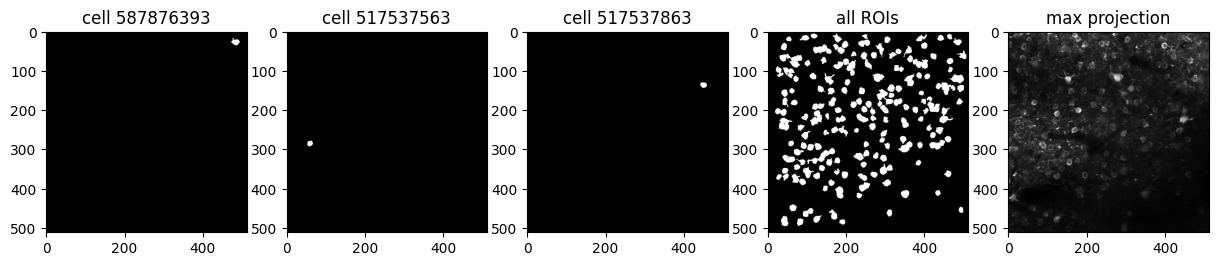

In [49]:
# get the specimen IDs for a few cells
cids = session_data.get_cell_specimen_ids()[:15:5]

# get ROI masks for the selected cells
selected_roi_masks = session_data.get_roi_mask_array(cell_specimen_ids=cids)

# plot each mask
f, axes = plt.subplots(1, len(cids)+2, figsize=(15, 3))
for ax, roi_mask, cid in zip(axes[:-2], selected_roi_masks, cids):
    ax.imshow(roi_mask, cmap='gray') 
    ax.set_title('cell %d' % cid)

# make a mask of all ROIs in the experiment    
all_roi_masks = session_data.get_roi_mask_array()
combined_mask = all_roi_masks.max(axis=0)
axes[-2].imshow(combined_mask, cmap='gray')
axes[-2].set_title('all ROIs')

# show the movie max projection
max_projection = session_data.get_max_projection()
axes[-1].imshow(max_projection, cmap='gray')
axes[-1].set_title('max projection')
plt.show()

# MODEL (Configuration)

In [50]:
%%capture

# Cloniamo il repository (per avere il codice sorgente)
!git clone https://github.com/bryanlimy/ViV1T.git
%cd ViV1T

# Installa il package
!pip install -e .

In [51]:
import torch
import sys
sys.path.append('./src')
import numpy as np

from viv1t.model import Model

In [97]:
sys.path.insert(0, '/kaggle/input/viv1t/transformers/default/5/')
from args import args_dict

In [99]:
import argparse
args = argparse.Namespace(**args_dictV2)

In [105]:
neuron_coordinates = {
    'A': neurons_coordinates_tensor
}

# Istanziamo il modello
viv1t = Model(args, neuron_coordinates=neuron_coordinates)


In [106]:
checkpoint = torch.load("/kaggle/input/viv1t/transformers/default/5/model_state.pt", map_location=args.device, weights_only=False)
state_dict = checkpoint['model']

filtered_checkpoint = {}
for key, value in state_dict.items():
    if key.startswith('core.'):
        filtered_checkpoint[key] = value

In [107]:
viv1t.load_state_dict(filtered_checkpoint, strict=False)
viv1t = viv1t.to(args.device)

In [108]:
viv1t

Model(
  (core): ViViTCore(
    (vivit): ViViT(
      (tokenizer): Tokenizer(
        (tokenizer): Sequential(
          (0): Unfold3d()
          (1): LayerNorm((6125,), eps=1e-05, elementwise_affine=True)
          (2): Linear(in_features=6125, out_features=112, bias=True)
          (3): LayerNorm((112,), eps=1e-05, elementwise_affine=True)
          (4): Dropout(p=0.1338, inplace=False)
        )
      )
      (spatial_transformer): Transformer(
        (blocks): ModuleList(
          (0-2): 3 x ParallelTransformerBlock(
            (norm): LayerNorm((112,), eps=1e-05, elementwise_affine=True)
            (fused_linear): Linear(in_features=112, out_features=1720, bias=False)
            (attn_out): Linear(in_features=528, out_features=112, bias=False)
            (ff_out): Sequential(
              (0): GELU(approximate='none')
              (1): Dropout(p=0.0592, inplace=False)
              (2): Linear(in_features=136, out_features=112, bias=False)
            )
            (drop_

# PEFT (LoRA)

In [109]:
import torch.nn as nn


# stampiamo tutti i layer lineari che ci sono nel modello
for name, module in viv1t.named_modules():
    if isinstance(module, nn.Linear):
        print(name)

core.vivit.tokenizer.tokenizer.2
core.vivit.spatial_transformer.blocks.0.fused_linear
core.vivit.spatial_transformer.blocks.0.attn_out
core.vivit.spatial_transformer.blocks.0.ff_out.2
core.vivit.spatial_transformer.blocks.1.fused_linear
core.vivit.spatial_transformer.blocks.1.attn_out
core.vivit.spatial_transformer.blocks.1.ff_out.2
core.vivit.spatial_transformer.blocks.2.fused_linear
core.vivit.spatial_transformer.blocks.2.attn_out
core.vivit.spatial_transformer.blocks.2.ff_out.2
core.vivit.temporal_transformer.blocks.0.fused_linear
core.vivit.temporal_transformer.blocks.0.attn_out
core.vivit.temporal_transformer.blocks.0.ff_out.2
core.vivit.temporal_transformer.blocks.1.fused_linear
core.vivit.temporal_transformer.blocks.1.attn_out
core.vivit.temporal_transformer.blocks.1.ff_out.2
core.vivit.temporal_transformer.blocks.2.fused_linear
core.vivit.temporal_transformer.blocks.2.attn_out
core.vivit.temporal_transformer.blocks.2.ff_out.2
core.vivit.temporal_transformer.blocks.3.fused_linea

Abbiamo riscontrato che non è possibile utilizzare direttamente `get_peft_model` poiché si va incontro ad un problema che è dovuto al fatto che PEFT (Parameter Efficient Fine-Tuning) è stato originariamente progettato per modelli di linguaggio come i transformer, e la libreria si aspetta parametri standard come input_ids, attention_mask, etc.
Il modello ViV1T ha invece una signature diversa per il metodo forward(), che accetta parametri come: inputs, mouse_id, behaviors, pupil_centers. Quando wrappato con PEFT, la libreria cerca di passare i parametri standard dei modelli di linguaggio.

Per questo motivo abbiamo provveduto creando un Wrapper che adattasse l'interfaccia del ViV1T a quella attesa da PEFT

In [110]:
import torch
import torch.nn as nn 
from peft import get_peft_model, LoraConfig, TaskType
import os
import warnings

# Sopprimiamo i warning di TensorFlow/CUDA
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

class ViV1TWrapper(nn.Module):
    """Wrapper per adattare ViV1T all'interfaccia PEFT"""
    
    def __init__(self, vivit_model):
        super().__init__()
        self.vivit_model = vivit_model
        
    def forward(self, input_ids=None, inputs=None, mouse_id=None, behaviors=None, pupil_centers=None, **kwargs):
        """
        Forward pass che gestisce sia l'interfaccia PEFT che quella originale
        """
        # Se vengono passati parametri PEFT, ignorali e usa i parametri del modello originale
        if inputs is not None:
            return self.vivit_model(
                inputs=inputs,
                mouse_id=mouse_id,
                behaviors=behaviors,
                pupil_centers=pupil_centers
            )
        else:
            raise ValueError("Missing required parameters for ViV1T model")

In [111]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,
    target_modules=["fused_linear", "attn_out", "ff_out.2"]
)

lora_model = get_peft_model(ViV1TWrapper(viv1t), config) 

lora_model.print_trainable_parameters()

trainable params: 174,080 || all params: 3,130,372 || trainable%: 5.5610


In [112]:
lora_model

PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): ViV1TWrapper(
      (vivit_model): Model(
        (core): ViViTCore(
          (vivit): ViViT(
            (tokenizer): Tokenizer(
              (tokenizer): Sequential(
                (0): Unfold3d()
                (1): LayerNorm((6125,), eps=1e-05, elementwise_affine=True)
                (2): Linear(in_features=6125, out_features=112, bias=True)
                (3): LayerNorm((112,), eps=1e-05, elementwise_affine=True)
                (4): Dropout(p=0.1338, inplace=False)
              )
            )
            (spatial_transformer): Transformer(
              (blocks): ModuleList(
                (0-2): 3 x ParallelTransformerBlock(
                  (norm): LayerNorm((112,), eps=1e-05, elementwise_affine=True)
                  (fused_linear): lora.Linear(
                    (base_layer): Linear(in_features=112, out_features=1720, bias=False)
                    (lora_dropout): ModuleDict(
                

**Proviamo a fare inferenza dopo l'applicazione di LoRA**

In [113]:
predictions, _ = lora_model(
    inputs=train_set[0]['video'].unsqueeze(0),
    mouse_id='A',
    behaviors=train_set[0]['behavior'].unsqueeze(0),
    pupil_centers=train_set[0]['pupil_center'].unsqueeze(0)
)

print(f"   Shape predizioni: {predictions.shape}")
print(f"   Range valori: [{predictions.min():.3f}, {predictions.max():.3f}]")

   Shape predizioni: torch.Size([1, 227, 116])
   Range valori: [0.798, 1.113]


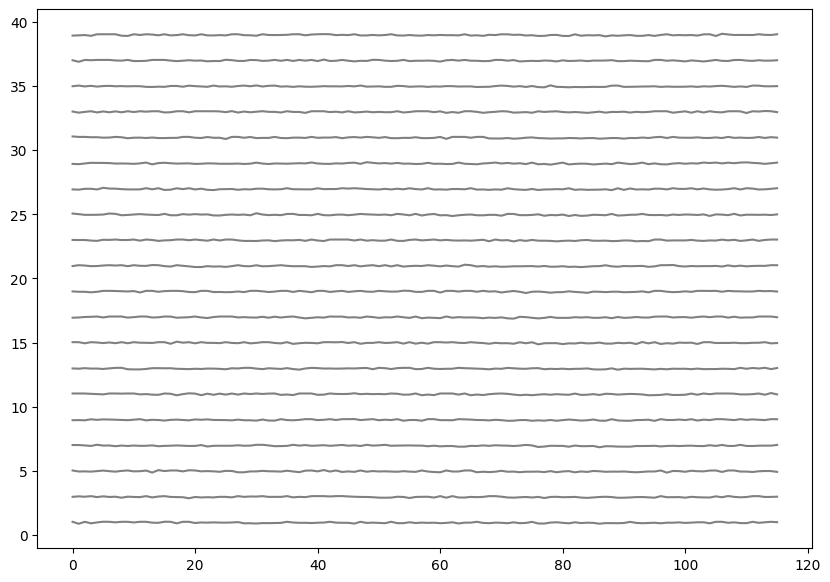

In [114]:
fig, ax = plt.subplots(figsize=(10,7))
predictions = predictions.cpu().detach().squeeze(0)

for i in range(20): 
    ax.plot(predictions[i,:]+(i*2), color='gray')

In [115]:
torch.cuda.empty_cache()
torch.cuda.synchronize()
free, _ = torch.cuda.mem_get_info()
print(f"Memoria GPU libera: {free / 1e9:.3f} GB")

Memoria GPU libera: 15.908 GB


In [116]:
import os
os.chdir('/kaggle/working')

print("Current directory:", os.getcwd())

Current directory: /kaggle/working


# CUSTOM HUGGINGFACE'S TRAINER

In [117]:
%%capture

!pip install huggingface_hub transformers
!pip install wandb -qqq

In [118]:
import wandb
from kaggle_secrets import UserSecretsClient
import os
from huggingface_hub import HfApi

user_secrets = UserSecretsClient() # per nascondere i token

wandb_key = user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_API_KEY"] = wandb_key

if wandb_key:
    wandb.login(key=wandb_key)
    print("Accesso a WandB effettuato con successo")


hf_hub_token = user_secrets.get_secret("HF_HUB_TOKEN")
os.environ["HF_HUB_TOKEN"] = hf_hub_token

if hf_hub_token:
    print("token hugging face hub recuperato con successo")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Accesso a WandB effettuato con successo
token hugging face hub recuperato con successo


In [119]:
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
from types import SimpleNamespace
import os
import warnings
# Sopprimiamo i warning di TensorFlow/CUDA
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

class ViViTTrainerWrapper(nn.Module):
    '''
     E' un adapter che permette al nostro modello di restituire le cose che si aspetta il trainer di Hugging Face
    '''
    def __init__(self, lora_model, mouse_id='A'):
        super().__init__()
        self.lora_model = lora_model
        self.mouse_id = mouse_id
        self.eps = torch.finfo(torch.float32).eps
       # self.mse_loss = nn.MSELoss()
    
    def _poisson_loss(self, y_true, y_pred):       
        y_true, y_pred = y_true + self.eps, y_pred + self.eps
        return torch.sum(y_pred - y_true * torch.log(y_pred))
    
    def forward(self, **kwargs): 
        inputs = kwargs.get('video')
        behaviors = kwargs.get('behavior')
        pupil_centers = kwargs.get('pupil_center')
        labels = kwargs.get('labels')
                
        predictions, _ = self.lora_model(
            inputs=inputs,
            mouse_id=self.mouse_id,
            behaviors=behaviors,
            pupil_centers=pupil_centers
        )
        
 
        loss = None
        if labels is not None:
            min_frames = 66
            labels_aligned = labels[..., -min_frames:]
            predictions_aligned = predictions[..., -min_frames:]
            loss = self._poisson_loss(labels_aligned, predictions_aligned)
            # loss = self.mse_loss(labels_aligned, predictions_aligned) 

        return {
            "loss": loss,
            "logits": predictions,  
        }

In [120]:
class CustomViViTTrainer(Trainer):
    """
     Estensione della classe con cui si istanzia il trainer al fine di overridare il prediction step
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """
        Viene chiamato automaticamente durante:
           - trainer.evaluate() per calcolare metriche sul validation set
           - trainer.predict() per generare predizioni sul test set
           - Durante il training se eval_strategy != "no"
        """       
        inputs = self._prepare_inputs(inputs) # assicura che tutti i tensori siano sul dispositivo corretto
        
        with torch.no_grad():
            with self.compute_loss_context_manager(): # garantiamo che tutte le configurazioni di precisione siano applicate
                outputs = model(**inputs)
                loss = outputs["loss"]
                logits = outputs["logits"]
        
        if prediction_loss_only:
            return (loss, None, None)
        
        # Estrai labels per compute_metrics
        labels = inputs.get('labels')
        
        return (loss, logits, labels)

In [121]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred 
    
    # Allineamento temporale
    min_frames = 66
    labels_aligned = labels[..., -min_frames:]
    predictions_aligned = predictions[..., -min_frames:]
    
    # Lista per memorizzare correlazioni per ogni esempio
    example_correlations = [] 
    
    # Loop per ogni esempio nel batch
    for example_idx in range(labels_aligned.shape[0]):
        # Dati per questo esempio specifico
        y_true_example = labels_aligned[example_idx].T  # (time, neurons)
        y_pred_example = predictions_aligned[example_idx].T  # (time, neurons)
        
        correlations = [] 
        
        for neuron in range(y_true_example.shape[1]):
            true_vals = y_true_example[:, neuron]
            pred_vals = y_pred_example[:, neuron]
            
      
            true_var = np.var(true_vals)
            pred_var = np.var(pred_vals)
            
            if true_var > 1e-10 and pred_var > 1e-10:
                corr = np.corrcoef(true_vals, pred_vals)[0, 1]
                if not np.isnan(corr) and np.isfinite(corr):
                    correlations.append(corr)
        
   
        mean_corr_example = np.mean(correlations) if correlations else 0.0
        example_correlations.append(mean_corr_example) 
    
    # Statistiche aggregate
    overall_mean = np.mean(example_correlations) if example_correlations else 0.0
    
    return {
        'eval_average_single_trial_correlation': overall_mean,
        'eval_single_trial_std': np.std(example_correlations) if example_correlations else 0.0,
        'eval_num_examples': len(example_correlations),
    }

# VIV1T - HEAD TUNING (MLP Shifter & Readout)

In [75]:
viv1t = Model(args, neuron_coordinates=neuron_coordinates)
checkpoint = torch.load("/kaggle/input/viv1t/transformers/default/5/model_state.pt", map_location=args.device, weights_only=False)
state_dict = checkpoint['model']

filtered_checkpoint = {}
for key, value in state_dict.items():
    if key.startswith('core.'):
        filtered_checkpoint[key] = value
        
viv1t.load_state_dict(filtered_checkpoint, strict=False)
viv1t = viv1t.to(args.device)

In [76]:
viv1t

Model(
  (core): ViViTCore(
    (vivit): ViViT(
      (tokenizer): Tokenizer(
        (tokenizer): Sequential(
          (0): Unfold3d()
          (1): LayerNorm((6125,), eps=1e-05, elementwise_affine=True)
          (2): Linear(in_features=6125, out_features=112, bias=True)
          (3): LayerNorm((112,), eps=1e-05, elementwise_affine=True)
          (4): Dropout(p=0.1338, inplace=False)
        )
      )
      (spatial_transformer): Transformer(
        (blocks): ModuleList(
          (0-2): 3 x ParallelTransformerBlock(
            (norm): LayerNorm((112,), eps=1e-05, elementwise_affine=True)
            (fused_linear): Linear(in_features=112, out_features=1720, bias=False)
            (attn_out): Linear(in_features=528, out_features=112, bias=False)
            (ff_out): Sequential(
              (0): GELU(approximate='none')
              (1): Dropout(p=0.0592, inplace=False)
              (2): Linear(in_features=136, out_features=112, bias=False)
            )
            (drop_

In [77]:
# Freeze tutti i parametri del modello
for param in viv1t.parameters():
   param.requires_grad = False
    
# Unfreeze solo shifters e readouts
for param in viv1t.shifters.parameters():
   param.requires_grad = True
   
for param in viv1t.readouts.parameters():
   param.requires_grad = True

In [233]:
training_args = TrainingArguments(

    # Configurazione Training
    num_train_epochs=25,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=7,  # Effective batch size = 7

    learning_rate=0.01, 
    remove_unused_columns=False, 
    dataloader_pin_memory=False, 

    # Ottimizzazione
    weight_decay=0.01, # regolarizzazione L2
    fp16=True,

    # Validation
    eval_strategy="epoch", 
    do_eval=True, # abilita l'esecuzione automatica della funzione compute_metrics sul validation set
    save_strategy="best",
    save_total_limit=1,

    # Model Selection
    output_dir="./results/Head-V2_ga7",
    metric_for_best_model="eval_average_single_trial_correlation", 
    greater_is_better=True,  
    load_best_model_at_end=True,  
    
    # Logging e Upload
    logging_steps=10, # Ogni 10 step di training salviamo le metriche e log
    report_to="wandb",

    # Hugging Face Hub Upload
    push_to_hub=False,  
    # hub_model_id= "Prv2106/ViV1T-Brain-Encoding-V1",
    hub_strategy="every_save",
    hub_token=hf_hub_token
)

In [234]:
viv1t_wrapped = ViViTTrainerWrapper(viv1t, mouse_id='A')

trainer_viv1t_wrapped = CustomViViTTrainer(
    model=viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

In [235]:
wandb.init(
    project="Brain-Encoding-ViV1T-Trainings",
    entity="provi-al2106-universit-catania",
    name="ViViT_Shifter_Readout_Only-V2_ga7",
    config={
        # Training arguments standard
        "learning_rate": training_args.learning_rate,  
        "epochs": training_args.num_train_epochs,
        "batch_size": training_args.per_device_train_batch_size,
        "lr_scheduler_type": training_args.lr_scheduler_type,
        "warmup_steps": training_args.warmup_steps,           
        "weight_decay": training_args.weight_decay,           
        "max_grad_norm": training_args.max_grad_norm,          
        
        # Model info
        "model_architecture": "ViViT_Shifter_Readout_Only",
        "optimizer_type": "AdamW_custom_lr",
        
        # Altre info utili per il debugging
        "gradient_accumulation_steps": training_args.gradient_accumulation_steps,
        "fp16": training_args.fp16,
        "save_strategy": training_args.save_strategy,
    }
)

eval/average_single_trial_correlation,▁▃▃▄▄▅▅▇▆▇▇▇▇▇▇██████▇
eval/loss,█▃▃▄▇▆▅▄▄▄▄▄▄▅▄▄▄▄▅▅▄▁
eval/model_preparation_time,▁▁
eval/num_examples,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
eval/samples_per_second,▄▄▁▅▇▇▆▂▂▇▅▆▅▇▆▆▄▆▇▂▅█
eval/single_trial_std,█▆▅▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
eval/steps_per_second,▄▄▁▅▇▇▆▂▂▇▅▆▅▇▆▆▄▆▇▂▅█
train/epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████▁
train/grad_norm,█▂▂▅▄▂▂▅▅▁▁▅▁▄▃▂▃▃▃▁▃▃▂▃▁▄▂▁▂▃▂▁▄▃▂▂▃▃▂▃


In [236]:
trainer_viv1t_wrapped.train()

Epoch,Training Loss,Validation Loss,Average Single Trial Correlation,Single Trial Std,Num Examples
1,40162.387500,4470.265625,0.010324,0.064897,31
2,29741.125000,3860.978271,0.009402,0.052911,31
3,26814.518700,3821.192383,0.012573,0.048602,31
4,25588.278100,3719.718994,0.011123,0.043631,31
5,26858.384400,3950.182129,0.013395,0.042346,31
6,25931.050000,4095.975098,0.012466,0.036743,31
7,21780.523400,3751.700684,0.013872,0.037798,31
8,23511.748400,3861.634766,0.016598,0.038708,31
9,22368.865600,3689.755371,0.017929,0.039665,31
10,24442.415600,3583.696289,0.018624,0.038893,31


TrainOutput(global_step=775, training_loss=24521.391824596772, metrics={'train_runtime': 978.1324, 'train_samples_per_second': 5.546, 'train_steps_per_second': 0.792, 'total_flos': 0.0, 'train_loss': 24521.391824596772, 'epoch': 25.0})

In [209]:
# vediamo qual è la Single Trial Correlation migliore (la nostra metrica di best model selection)
trainer_viv1t_wrapped.state.best_metric

0.012054041013497175

In [217]:
# SANITY CHECK
validation_results = trainer_viv1t_wrapped.evaluate(eval_dataset=validation_set)
print(f"Risultati (eval_single_trial_correlation) sul validation set: {validation_results['eval_average_single_trial_correlation']}")

Risultati (eval_single_trial_correlation) sul validation set: 0.012054041013497175


In [237]:
from huggingface_hub import HfApi

api = HfApi()

api.create_repo(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    token=hf_hub_token,
    private=False,  
    exist_ok=True  
)


api.upload_folder(
    folder_path="./results/Head-V2_ga7/checkpoint-775",
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    path_in_repo="experiments/Head-V2_ga7/checkpoint-775/",
    token=hf_hub_token
)

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/333k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments/commit/5caf529e4733d51f9872442940542373d23ddc84', commit_message='Upload folder using huggingface_hub', commit_description='', oid='5caf529e4733d51f9872442940542373d23ddc84', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments', endpoint='https://huggingface.co', repo_type='model', repo_id='Prv2106/ViV1T-Brain-Encoding-All-Experiments'), pr_revision=None, pr_num=None)

In [239]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file


our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/Head-V2_ga7/checkpoint-775/model.safetensors",  
    token=hf_hub_token
)

state_dict = load_file(our_checkpoint_path)

viv1t = Model(args, neuron_coordinates=neuron_coordinates)
viv1t = viv1t.to(args.device)
viv1t_wrapped = ViViTTrainerWrapper(viv1t, mouse_id='A')

viv1t_wrapped.load_state_dict(state_dict)

trainer_viv1t_wrapped = CustomViViTTrainer(
    model=viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

# SANITY CHECK
validation_results = trainer_viv1t_wrapped.evaluate(eval_dataset=validation_set)
print(f"Risultati (eval_single_trial_correlation) sul validation set: {validation_results['eval_average_single_trial_correlation']}")

# Valutazione del modello sui dati di test
test_results = trainer_viv1t_wrapped.evaluate(eval_dataset=test_set)
print(f"Risultati (eval_single_trial_correlation) sul test set: {test_results['eval_average_single_trial_correlation']}")

model.safetensors:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

Risultati (eval_single_trial_correlation) sul validation set: 0.0222950308209172
Risultati (eval_single_trial_correlation) sul test set: 0.01342675260288661


# VIV1T - LoRA + HEAD FINETUNING

## LoRA 8

In [172]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,
    target_modules=["fused_linear", "attn_out", "ff_out.2"]
)

In [173]:
viv1t = Model(args, neuron_coordinates=neuron_coordinates)

checkpoint = torch.load("/kaggle/input/viv1t/transformers/default/5/model_state.pt", map_location=args.device, weights_only=False)
state_dict = checkpoint['model']

filtered_checkpoint = {}
for key, value in state_dict.items():
    if key.startswith('core.'):
        filtered_checkpoint[key] = value

viv1t.load_state_dict(filtered_checkpoint, strict=False)
        
viv1t = viv1t.to(args.device)

lora_model = get_peft_model(ViV1TWrapper(viv1t), config) 

lora_model.print_trainable_parameters()

trainable params: 174,080 || all params: 3,130,362 || trainable%: 5.5610


In [174]:
# Per unfreezing dei readouts
for param in lora_model.base_model.model.vivit_model.shifters.parameters():
    param.requires_grad = True
    
for param in lora_model.base_model.model.vivit_model.readouts.parameters():
    param.requires_grad = True
    
lora_model.print_trainable_parameters()

trainable params: 214,288 || all params: 3,130,362 || trainable%: 6.8455


In [177]:
training_args = TrainingArguments(
   
    # Configurazione Training
    num_train_epochs=20,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=7,  # Effective batch size = 7
    

    per_device_eval_batch_size=1,
    learning_rate=args.lr, 
    remove_unused_columns=False, 
    dataloader_pin_memory=False, 

    # Ottimizzazione
    weight_decay=0.01, # regolarizzazione L2
    fp16=True,

    # Validation
    eval_strategy="epoch",
    save_total_limit=1,
    do_eval=True, # abilita l'esecuzione automatica della funzione compute_metrics sul validation set
    save_strategy="best",

    # Model Selection
    output_dir="./results/LoRA-8-V1_ga7_MSE_loss",
    metric_for_best_model="eval_average_single_trial_correlation", 
    greater_is_better=True,  
    load_best_model_at_end=True,  
    
    # Logging e Upload
    logging_steps=10, # Ogni 10 step di training salviamo le metriche e log
    report_to="wandb",

    # Hugging Face Hub Upload
    push_to_hub=False,  
   # hub_model_id= "Prv2106/ViV1T-Brain-Encoding-LoRA-8-V1_ga7",
    hub_strategy="every_save",
    hub_token=hf_hub_token
)

In [178]:
lora_viv1t_wrapped = ViViTTrainerWrapper(lora_model, mouse_id='A')

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

In [179]:
wandb.init(
    project="Brain-Encoding-ViV1T-Trainings",
    entity="provi-al2106-universit-catania",
    name="ViViT_LoRA-8-V1_ga7_MSE_loss",
    config={
        # Training arguments standard
        "learning_rate": training_args.learning_rate,  
        "epochs": training_args.num_train_epochs,
        "batch_size": training_args.per_device_train_batch_size,
        "lr_scheduler_type": training_args.lr_scheduler_type,
        "warmup_steps": training_args.warmup_steps,           
        "weight_decay": training_args.weight_decay,           
        "max_grad_norm": training_args.max_grad_norm,          
        
        # LoRA configuration
        "lora_r": 8,
        "lora_alpha": 16,
        "lora_dropout": 0.1,    
        
        # Model info
        "model_architecture": "ViViT_LoRA-8-V1_ga7_MSE_loss",
        "optimizer_type": "AdamW_custom_lr",
        
        # Altre info utili per il debugging
        "gradient_accumulation_steps": training_args.gradient_accumulation_steps,
        "fp16": training_args.fp16,
        "save_strategy": training_args.save_strategy,
    }
)

eval/average_single_trial_correlation,▁▆▅▅▃▆▆▆▆▆▄█▇█▆█▅▇▆▆█▇█▇█▄
eval/loss,▂▃▂▂▅▃▅▃▄▄▄▅▆▆▅▅▅█▄▇▆▆█▄▅▁
eval/model_preparation_time,▁
eval/num_examples,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
eval/samples_per_second,▄▅▁▅▆▆▆▇▇▇▇▇▇▇███▆▇▆▆▆▆▆▆▅
eval/single_trial_std,▅▄▃█▅▅██▇▄▃▅▄▄▁▃▂▂▂▂▂▂▂▂▂▁
eval/steps_per_second,▄▅▁▅▆▆▆▇▇▇▇▇▇▇███▆▇▆▆▆▆▆▆▅
train/epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train/grad_norm,▄▂▃▅▄▂▂▄▂▅▄▅▄█▃▃▅▄▄▂▃▄▁▂▁▂▄▂▆▁▅▅▆▆█▇▁▇▇


In [180]:
# Avvia il training
trainer_lora_viv1t_wrapped.train()

Epoch,Training Loss,Validation Loss,Average Single Trial Correlation,Single Trial Std,Num Examples
1,7.439100,0.862816,-0.021253,0.071176,31
2,6.437900,0.849713,-0.004351,0.089599,31
3,6.431500,0.860831,0.001112,0.108102,31
4,6.661200,0.870399,0.006214,0.103885,31
5,7.284200,0.864125,-0.000676,0.073311,31
6,6.804500,0.849112,-0.003874,0.068715,31
7,5.766800,0.853410,-0.000606,0.075438,31
8,7.419000,0.962725,-0.005172,0.072357,31
9,7.266700,1.515764,-0.000683,0.074049,31
10,7.314000,0.865559,0.020492,0.067132,31


TrainOutput(global_step=620, training_loss=6.569991271726547, metrics={'train_runtime': 2334.6344, 'train_samples_per_second': 1.859, 'train_steps_per_second': 0.266, 'total_flos': 0.0, 'train_loss': 6.569991271726547, 'epoch': 20.0})

In [181]:
from huggingface_hub import HfApi

api = HfApi()


api.create_repo(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    token=hf_hub_token,
    private=False,  
    exist_ok=True  
)


api.upload_folder(
    folder_path="./results/LoRA-8-V1_ga7_MSE_loss/checkpoint-434",
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    path_in_repo="experiments/LoRA-8-V1_ga7_MSE_loss/checkpoint-434/",
    token=hf_hub_token
)

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments/commit/5435bb2e4a4466412b57b9c1b772f75fad7212ca', commit_message='Upload folder using huggingface_hub', commit_description='', oid='5435bb2e4a4466412b57b9c1b772f75fad7212ca', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments', endpoint='https://huggingface.co', repo_type='model', repo_id='Prv2106/ViV1T-Brain-Encoding-All-Experiments'), pr_revision=None, pr_num=None)

In [182]:
# vediamo qual è la Single Trial Correlation migliore (la nostra metrica di best model selection)
trainer_lora_viv1t_wrapped.state.best_metric

0.024547538574669996

In [169]:
# SANITY CHECK
validation_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=validation_set)
print(f"Risultati (eval_single_trial_correlation) sul validation set: {validation_results['eval_average_single_trial_correlation']}")

Risultati (eval_single_trial_correlation) sul validation set: 0.03960408847254126


In [183]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file


our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/LoRA-8-V1_ga7_MSE_loss/checkpoint-434/model.safetensors",  
    token=hf_hub_token
)

state_dict = load_file(our_checkpoint_path)

lora_viv1t_wrapped.load_state_dict(state_dict)

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

# Valutazione del modello sui dati di test
test_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)
print(f"Risultati (eval_single_trial_correlation) sul test set: {test_results['eval_average_single_trial_correlation']}")

model.safetensors:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Risultati (eval_single_trial_correlation) sul test set: 0.02125960715599922


## LorA 16

In [254]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,
    target_modules=["fused_linear", "attn_out", "ff_out.2"]
)

In [188]:
viv1t = Model(args, neuron_coordinates=neuron_coordinates)

checkpoint = torch.load("/kaggle/input/viv1t/transformers/default/5/model_state.pt", map_location=args.device, weights_only=False)
state_dict = checkpoint['model']

filtered_checkpoint = {}
for key, value in state_dict.items():
    if key.startswith('core.'):
        filtered_checkpoint[key] = value

viv1t.load_state_dict(filtered_checkpoint, strict=False)
        
viv1t = viv1t.to(args.device)

lora_model = get_peft_model(ViV1TWrapper(viv1t), config) 

lora_model.print_trainable_parameters()

trainable params: 348,160 || all params: 3,304,442 || trainable%: 10.5361


In [189]:
# Per unfreezing dei readouts
for param in lora_model.base_model.model.vivit_model.shifters.parameters():
    param.requires_grad = True
    
for param in lora_model.base_model.model.vivit_model.readouts.parameters():
    param.requires_grad = True
    
lora_model.print_trainable_parameters()

trainable params: 388,368 || all params: 3,304,442 || trainable%: 11.7529


In [306]:
training_args = TrainingArguments(

    # Configurazione Training
    num_train_epochs=20,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=7,  # Effective batch size = 7

    per_device_eval_batch_size=1,
    learning_rate=args.lr, 
    remove_unused_columns=False, 
    dataloader_pin_memory=False, 

    # Ottimizzazione
    weight_decay=0.01, # regolarizzazione L2
    fp16=True,

    # Validation
    eval_strategy="epoch", 
    do_eval=True, # abilita l'esecuzione automatica della funzione compute_metrics sul validation set
    save_strategy="best",
    save_total_limit=1,

    # Model Selection
    output_dir="./results/LoRA-16-V1_ga7",
    metric_for_best_model="eval_average_single_trial_correlation", 
    greater_is_better=True,  
    load_best_model_at_end=True,  
    
    # Logging e Upload
    logging_steps=10, # Ogni 10 step di training salviamo le metriche e log
    report_to="wandb",

    # Hugging Face Hub Upload
    push_to_hub=False,  
    # hub_model_id= "Prv2106/ViV1T-Brain-Encoding-LoRA-16-V1_ga7",
    hub_strategy="every_save",
    hub_token=hf_hub_token
)

In [191]:
lora_viv1t_wrapped = ViViTTrainerWrapper(lora_model, mouse_id='A')

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

In [192]:
wandb.init(
    project="Brain-Encoding-ViV1T-Trainings",
    entity="provi-al2106-universit-catania",
    name="ViViT_LoRA-16-V1_ga7",
    config={
        # Training arguments standard
        "learning_rate": training_args.learning_rate,  
        "epochs": training_args.num_train_epochs,
        "batch_size": training_args.per_device_train_batch_size,
        "lr_scheduler_type": training_args.lr_scheduler_type,
        "warmup_steps": training_args.warmup_steps,           
        "weight_decay": training_args.weight_decay,           
        "max_grad_norm": training_args.max_grad_norm,          
        
        # LoRA configuration
        "lora_r": 16,
        "lora_alpha": 32,
        "lora_dropout": 0.1,    
        
        # Model info
        "model_architecture": "ViViT_LoRA-16-V1_ga7",
        "optimizer_type": "AdamW_custom_lr",
        
        # Altre info utili per il debugging
        "gradient_accumulation_steps": training_args.gradient_accumulation_steps,
        "fp16": training_args.fp16,
        "save_strategy": training_args.save_strategy,
    }
)

In [193]:
# Avvia il training
trainer_lora_viv1t_wrapped.train()

Epoch,Training Loss,Validation Loss,Average Single Trial Correlation,Single Trial Std,Num Examples
1,31123.128100,3736.718994,-0.015787,0.084025,31
2,26613.065600,3467.365967,-0.001211,0.097137,31
3,25283.021900,3537.577637,0.006422,0.058814,31
4,24861.367200,3413.042725,0.002587,0.095362,31
5,26556.746900,3491.453125,0.014162,0.079895,31
6,25759.946900,3367.439453,0.009216,0.061347,31
7,22295.042200,3446.410400,0.030765,0.034860,31
8,23146.090600,3846.567139,0.017513,0.040437,31
9,21817.107800,3340.588379,0.025002,0.034214,31
10,21230.150000,3454.199951,0.027115,0.061090,31


TrainOutput(global_step=620, training_loss=20164.682544732863, metrics={'train_runtime': 2355.9039, 'train_samples_per_second': 1.842, 'train_steps_per_second': 0.263, 'total_flos': 0.0, 'train_loss': 20164.682544732863, 'epoch': 20.0})

In [ ]:
# vediamo qual è la Single Trial Correlation migliore (la nostra metrica di best model selection)
trainer_lora_viv1t_wrapped.state.best_metric

In [196]:
# SANITY CHECK
validation_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=validation_set)
print(f"Risultati (eval_single_trial_correlation) sul validation set: {validation_results['eval_average_single_trial_correlation']}")

Risultati (eval_single_trial_correlation) sul validation set: 0.05278563151066321


In [194]:
from huggingface_hub import HfApi

api = HfApi()


api.create_repo(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    token=hf_hub_token,
    private=False,  
    exist_ok=True  
)


api.upload_folder(
    folder_path="./results/LoRA-16-V1_ga7/checkpoint-527",
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    path_in_repo="experiments/LoRA-16-V1_ga7/checkpoint-527/",
    token=hf_hub_token
)

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments/commit/3453b4bfdbadfbde80860bffbb30eec2d50d4ea3', commit_message='Upload folder using huggingface_hub', commit_description='', oid='3453b4bfdbadfbde80860bffbb30eec2d50d4ea3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments', endpoint='https://huggingface.co', repo_type='model', repo_id='Prv2106/ViV1T-Brain-Encoding-All-Experiments'), pr_revision=None, pr_num=None)

In [197]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file


our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/LoRA-16-V1_ga7/checkpoint-527/model.safetensors",  
    token=hf_hub_token
)

state_dict = load_file(our_checkpoint_path)

lora_viv1t_wrapped.load_state_dict(state_dict)

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)


# SANITY CHECK
validation_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=validation_set)
print(f"Risultati (eval_single_trial_correlation) sul validation set: {validation_results['eval_average_single_trial_correlation']}")
print("\n")

# Valutazione del modello sui dati di test
test_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)
print(f"Risultati (eval_single_trial_correlation) sul test set: {test_results['eval_average_single_trial_correlation']}")

Risultati (eval_single_trial_correlation) sul validation set: 0.05278563151066321


Risultati (eval_single_trial_correlation) sul test set: 0.04315708382100358


### LoRA 16 Head FineTuning
Facciamo un ulteriore Finetuning freezando stavolta i pesi di LoRA (quindi solo head Finetuning)

In [289]:
training_args = TrainingArguments(

    # Configurazione Training
    num_train_epochs=20,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=7,  # Effective batch size = 7

    per_device_eval_batch_size=1,
    learning_rate=0.0001, 
    remove_unused_columns=False, 
    dataloader_pin_memory=False, 

    # Ottimizzazione
    weight_decay=0.01, # regolarizzazione L2
    fp16=True,

    # Validation
    eval_strategy="epoch", 
    do_eval=True, # abilita l'esecuzione automatica della funzione compute_metrics sul validation set
    save_strategy="best",
    save_total_limit=1,

    # Model Selection
    output_dir="./results/LoRA-16-V1_ga7-Head_ft_ga7-V3",
    metric_for_best_model="eval_average_single_trial_correlation", 
    greater_is_better=True,  
    load_best_model_at_end=True,  
    
    # Logging e Upload
    logging_steps=10, # Ogni 10 step di training salviamo le metriche e log
    report_to="wandb",

    # Hugging Face Hub Upload
    push_to_hub=False,  
    hub_strategy="every_save",
    hub_token=hf_hub_token
)

In [290]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file


our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/LoRA-16-V1_ga7/checkpoint-527/model.safetensors",  
    token=hf_hub_token
)


state_dict = load_file(our_checkpoint_path)
viv1t = Model(args, neuron_coordinates=neuron_coordinates)

lora_model = get_peft_model(ViV1TWrapper(viv1t), config) 


lora_viv1t_wrapped = ViViTTrainerWrapper(lora_model, mouse_id='A')


lora_viv1t_wrapped.load_state_dict(state_dict)

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

validation_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)
print(f"Risultati (eval_single_trial_correlation) sul test_set set: {validation_results['eval_average_single_trial_correlation']}")

Risultati (eval_single_trial_correlation) sul test_set set: 0.04315708382100358


In [291]:
# Freezo tutto il modello
for param in lora_viv1t_wrapped.parameters():
    param.requires_grad = False

# Unfreezo solo shifter e readout
for name, param in lora_viv1t_wrapped.named_parameters():
    if 'shifters' in name or 'readouts' in name:
        param.requires_grad = True

In [292]:
# Verifica che siano solo shifter e readout
for name, param in lora_viv1t_wrapped.named_parameters():
    if param.requires_grad:
        print(name)

lora_model.base_model.model.vivit_model.shifters.A.mlp.0.weight
lora_model.base_model.model.vivit_model.shifters.A.mlp.0.bias
lora_model.base_model.model.vivit_model.shifters.A.mlp.2.weight
lora_model.base_model.model.vivit_model.shifters.A.mlp.2.bias
lora_model.base_model.model.vivit_model.shifters.A.mlp.4.weight
lora_model.base_model.model.vivit_model.shifters.A.mlp.4.bias
lora_model.base_model.model.vivit_model.readouts.A.sigma
lora_model.base_model.model.vivit_model.readouts.A.features
lora_model.base_model.model.vivit_model.readouts.A.bias
lora_model.base_model.model.vivit_model.readouts.A.mu_transform.0.weight
lora_model.base_model.model.vivit_model.readouts.A.mu_transform.0.bias
lora_model.base_model.model.vivit_model.readouts.A.mu_transform.2.weight
lora_model.base_model.model.vivit_model.readouts.A.mu_transform.2.bias
lora_model.base_model.model.vivit_model.readouts.A.state_encoder.0.weight
lora_model.base_model.model.vivit_model.readouts.A.state_encoder.0.bias
lora_model.base

In [293]:
wandb.init(
    project="Brain-Encoding-ViV1T-Trainings",
    entity="provi-al2106-universit-catania",
    name="ViViT_LoRA-16-V1_ga7-Head_ft_ga7-V3_lr=0.0001",
    config={
        # Training arguments standard
        "learning_rate": training_args.learning_rate,  
        "epochs": training_args.num_train_epochs,
        "batch_size": training_args.per_device_train_batch_size,
        "lr_scheduler_type": training_args.lr_scheduler_type,
        "warmup_steps": training_args.warmup_steps,           
        "weight_decay": training_args.weight_decay,           
        "max_grad_norm": training_args.max_grad_norm,          
        
        # LoRA configuration
        "lora_r": 16,
        "lora_alpha": 32,
        "lora_dropout": 0.1,    
        
        # Model info
        "model_architecture": "ViViT_LoRA-16-V1_ga7-Head_ft_ga7-V3_lr=0.0001",
        "optimizer_type": "AdamW_custom_lr",
        
        # Altre info utili per il debugging
        "gradient_accumulation_steps": training_args.gradient_accumulation_steps,
        "fp16": training_args.fp16,
        "save_strategy": training_args.save_strategy,
    }
)

eval/average_single_trial_correlation,███████▇█▇▇▇▇▇▇▇▇▇▇▇▂▁
eval/loss,▄▁▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄█▇
eval/model_preparation_time,████████████████████▆▁
eval/num_examples,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
eval/samples_per_second,▇▅▇▇▇▇█▆▇▆▆█▂▆▃▂▄▇▆▁▄▁
eval/single_trial_std,███▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▆▆▂▁
eval/steps_per_second,▇▅▇▇▇▇█▆▇▆▆█▂▆▃▂▄▇▆▁▄▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████▁
train/grad_norm,▂█▂▂▂▃▄▃▄▄▃▂▄▅▃▃▂▂▂▂▂▂▁▂▂▁▂▃▂▃▁▄▃▃▂▃▅▂▃▄


In [294]:
trainer_lora_viv1t_wrapped.train()

Epoch,Training Loss,Validation Loss,Average Single Trial Correlation,Single Trial Std,Num Examples,Model Preparation Time
1,7972.190600,2609.936523,0.053018,0.087732,31,0.003100
2,6548.560500,2599.539795,0.053257,0.088064,31,0.003100
3,9491.141400,2591.219482,0.053332,0.088162,31,0.003100
4,6646.954700,2581.445801,0.053328,0.088146,31,0.003100
5,8146.546100,2577.523438,0.053300,0.088150,31,0.003100
6,7666.372700,2574.965332,0.053309,0.088124,31,0.003100
7,3526.238300,2574.273926,0.053284,0.088137,31,0.003100
8,3657.674200,2574.204102,0.053248,0.088125,31,0.003100
9,5069.835500,2575.458740,0.053291,0.088157,31,0.003100
10,5070.184800,2575.958984,0.053245,0.088145,31,0.003100


TrainOutput(global_step=620, training_loss=6450.6704857610885, metrics={'train_runtime': 990.2959, 'train_samples_per_second': 4.383, 'train_steps_per_second': 0.626, 'total_flos': 0.0, 'train_loss': 6450.6704857610885, 'epoch': 20.0})

In [295]:
from huggingface_hub import HfApi

api = HfApi()


api.create_repo(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    token=hf_hub_token,
    private=False,  
    exist_ok=True  
)


api.upload_folder(
    folder_path="./results/LoRA-16-V1_ga7-Head_ft_ga7-V3/checkpoint-93",
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    path_in_repo="experiments/LoRA-16-V1_ga7-Head_ft_ga7-V3/checkpoint-93/",
    token=hf_hub_token
)

optimizer.pt:   0%|          | 0.00/333k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments/commit/a5cac319ab0527eb984271e5dc3436a87cea28ad', commit_message='Upload folder using huggingface_hub', commit_description='', oid='a5cac319ab0527eb984271e5dc3436a87cea28ad', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments', endpoint='https://huggingface.co', repo_type='model', repo_id='Prv2106/ViV1T-Brain-Encoding-All-Experiments'), pr_revision=None, pr_num=None)

In [296]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file


our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/LoRA-16-V1_ga7-Head_ft_ga7-V2/checkpoint-93/model.safetensors",  
    token=hf_hub_token
)


state_dict = load_file(our_checkpoint_path)
viv1t = Model(args, neuron_coordinates=neuron_coordinates)

lora_model = get_peft_model(ViV1TWrapper(viv1t), config) 


lora_viv1t_wrapped = ViViTTrainerWrapper(lora_model, mouse_id='A')


lora_viv1t_wrapped.load_state_dict(state_dict)

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

validation_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)
print(f"Risultati (eval_single_trial_correlation) sul test_set set: {validation_results['eval_average_single_trial_correlation']}")

Risultati (eval_single_trial_correlation) sul test_set set: 0.04526438617531962


In [275]:
# SANITY CHECK
validation_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=validation_set)
print(f"Risultati (eval_single_trial_correlation) sul validation set: {validation_results['eval_average_single_trial_correlation']}")

Risultati (eval_single_trial_correlation) sul validation set: 0.05151513066733686


In [ ]:
# Valutazione del modello sui dati di test
test_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)
print(f"Risultati (eval_single_trial_correlation) sul test set: {test_results['eval_average_single_trial_correlation']}")

### LoRA 32

In [147]:
config = LoraConfig(
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,
    target_modules=["fused_linear", "attn_out", "ff_out.2"]
)

In [148]:
viv1t = Model(args, neuron_coordinates=neuron_coordinates)

checkpoint = torch.load("/kaggle/input/viv1t/transformers/default/5/model_state.pt", map_location=args.device, weights_only=False)
state_dict = checkpoint['model']

filtered_checkpoint = {}
for key, value in state_dict.items():
    if key.startswith('core.'):
        filtered_checkpoint[key] = value

viv1t.load_state_dict(filtered_checkpoint, strict=False)
        
viv1t = viv1t.to(args.device)

lora_model = get_peft_model(ViV1TWrapper(viv1t), config) 

lora_model.print_trainable_parameters()

trainable params: 696,320 || all params: 3,652,612 || trainable%: 19.0636


In [149]:
# Per unfreezing dei readouts
for param in lora_model.base_model.model.vivit_model.shifters.parameters():
    param.requires_grad = True
    
for param in lora_model.base_model.model.vivit_model.readouts.parameters():
    param.requires_grad = True
    
lora_model.print_trainable_parameters()

trainable params: 736,538 || all params: 3,652,612 || trainable%: 20.1647


In [150]:
training_args = TrainingArguments(

    # Configurazione Training
    num_train_epochs=40,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=7,  # Effective batch size = 7

    per_device_eval_batch_size=1,
    learning_rate=0.004, 
    remove_unused_columns=False, 
    dataloader_pin_memory=False, 

    # Ottimizzazione
    weight_decay=0.01, # regolarizzazione L2
    fp16=True,

    # Validation
    eval_strategy="epoch", 
    do_eval=True, # abilita l'esecuzione automatica della funzione compute_metrics sul validation set
    save_strategy="best",
    save_total_limit=1,

    # Model Selection
    output_dir="./results/LoRA-32-V2_ga7_shifter_mode2",
    metric_for_best_model="eval_average_single_trial_correlation", 
    greater_is_better=True,  
    load_best_model_at_end=True,  
    
    # Logging e Upload
    logging_steps=10, # Ogni 10 step di training salviamo le metriche e log
    report_to="wandb",

    # Hugging Face Hub Upload
    push_to_hub=False,  
    hub_strategy="every_save",
    hub_token=hf_hub_token
)

In [151]:
lora_viv1t_wrapped = ViViTTrainerWrapper(lora_model, mouse_id='A')

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

In [152]:
wandb.init(
    project="Brain-Encoding-ViV1T-Trainings",
    entity="provi-al2106-universit-catania",
    name="ViViT_LoRA-32-V2_ga7_shifter_mode2_lr=0.004",
    config={
        # Training arguments standard
        "learning_rate": training_args.learning_rate,  
        "epochs": training_args.num_train_epochs,
        "batch_size": training_args.per_device_train_batch_size,
        "lr_scheduler_type": training_args.lr_scheduler_type,
        "warmup_steps": training_args.warmup_steps,           
        "weight_decay": training_args.weight_decay,           
        "max_grad_norm": training_args.max_grad_norm,          
        
        # LoRA configuration
        "lora_r": 32,
        "lora_alpha": 64,
        "lora_dropout": 0.1,    
        
        # Model info
        "model_architecture": "ViViT_LoRA-32-V2_ga7_shifter_mode2",
        "optimizer_type": "AdamW_custom_lr",
        
        # Altre info utili per il debugging
        "gradient_accumulation_steps": training_args.gradient_accumulation_steps,
        "fp16": training_args.fp16,
        "save_strategy": training_args.save_strategy,
    }
)

eval/average_single_trial_correlation,▁▁▂▂▃▃▄▄▆▅▇▆█▇▇▆▆
eval/loss,█▁▂▂▂▂▂▂▁▂▂▂▁▂▁▂▂
eval/num_examples,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▇█▁▃▁▂▄▇▅▃▄▄▄▅▃▅▄
eval/samples_per_second,▂▁▇▆█▇▅▂▄▆▅▅▅▄▅▄▅
eval/single_trial_std,▃▃▅▆███▅▂▃▁▁▂▁▂▄▃
eval/steps_per_second,▂▁▇▆█▇▅▂▄▆▅▅▅▄▅▄▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/grad_norm,▂█▃▂▃▃▂▃▂▄▁▂▁▃▂▃▂▂▂▂▂▂▁▂▂▂▂▂▁▃▂▂▂▂▂▂▄▃▂
train/learning_rate,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁


In [153]:
# Avvia il training
trainer_lora_viv1t_wrapped.train()

Epoch,Training Loss,Validation Loss,Average Single Trial Correlation,Single Trial Std,Num Examples
1,30283.696900,3360.881836,0.000434,0.085963,31
2,26953.859400,4116.094238,0.005679,0.099775,31
3,25722.534400,3609.170898,-0.001102,0.070468,31
4,25864.412500,3890.022949,-0.003033,0.057023,31
5,27845.006200,3633.769043,0.004216,0.062701,31
6,26524.840600,3684.626221,0.012869,0.041392,31
7,22473.362500,3661.979736,-0.003841,0.077723,31
8,24466.687500,3533.700928,0.017119,0.046315,31
9,24165.407800,3534.505371,0.023616,0.042316,31
10,24187.675000,3276.523682,0.022990,0.073785,31


TrainOutput(global_step=1240, training_loss=13494.42913365518, metrics={'train_runtime': 5035.4207, 'train_samples_per_second': 1.724, 'train_steps_per_second': 0.246, 'total_flos': 0.0, 'train_loss': 13494.42913365518, 'epoch': 40.0})

In [154]:
from huggingface_hub import HfApi

api = HfApi()


api.create_repo(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    token=hf_hub_token,
    private=False,  
    exist_ok=True  
)


api.upload_folder(
    folder_path="./results/LoRA-32-V2_ga7_shifter_mode2/checkpoint-899",
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    path_in_repo="experiments/LoRA-32-V2_ga7_shifter_mode2/checkpoint-899/",
    token=hf_hub_token
)

optimizer.pt:   0%|          | 0.00/5.94M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments/commit/742a3aa0c88b9aa7c7b6debcf819a5cf3b6e00e7', commit_message='Upload folder using huggingface_hub', commit_description='', oid='742a3aa0c88b9aa7c7b6debcf819a5cf3b6e00e7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Prv2106/ViV1T-Brain-Encoding-All-Experiments', endpoint='https://huggingface.co', repo_type='model', repo_id='Prv2106/ViV1T-Brain-Encoding-All-Experiments'), pr_revision=None, pr_num=None)

In [101]:
# vediamo qual è la Single Trial Correlation migliore (la nostra metrica di best model selection)
trainer_lora_viv1t_wrapped.state.best_metric

0.04865820277069099

In [102]:
# SANITY CHECK
validation_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=validation_set)
print(f"Risultati (eval_single_trial_correlation) sul validation set: {validation_results['eval_average_single_trial_correlation']}")

Risultati (eval_single_trial_correlation) sul validation set: 0.04557550789204197


In [155]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/LoRA-32-V2_ga7_shifter_mode2/checkpoint-899/model.safetensors",  
    token=hf_hub_token
)

# Carica il checkpoint
state_dict = load_file(our_checkpoint_path)

lora_viv1t_wrapped.load_state_dict(state_dict)

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)


# SANITY CHECK
validation_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=validation_set)
print(f"Risultati (eval_single_trial_correlation) sul validation set: {validation_results['eval_average_single_trial_correlation']}")

# Valutazione del modello sui dati di test
test_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)
print(f"Risultati (eval_single_trial_correlation) sul test set: {test_results['eval_average_single_trial_correlation']}")

model.safetensors:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Risultati (eval_single_trial_correlation) sul validation set: 0.06016454681377796
Risultati (eval_single_trial_correlation) sul test set: 0.048809432041202305


# RESULTS W.R.T. BASELINE

In [157]:
baseline_result = 0.022245158045881203 

In [158]:
def print_result(test_results):
    ratio = test_results/baseline_result
    if ratio < 1:
        print("Non ha avuto senso fare tutto ciò... ovvero, il modello riesce a spiegare meno dei dati stessi")
    elif ratio > 1:
        print(f"Il modello sta spiegando non solo la media, ma anche qualcosa in più (migliore di {ratio:.2f}) volte")
    else:
        print("Sono uguali")

## ViV1T Shifter & Readout only

In [301]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/Head-V1/checkpoint-434/model.safetensors",  
    token=hf_hub_token
)

state_dict = load_file(our_checkpoint_path)

viv1t = Model(args, neuron_coordinates=neuron_coordinates)
viv1t = viv1t.to(args.device)
viv1t_wrapped = ViViTTrainerWrapper(viv1t, mouse_id='A')

viv1t_wrapped.load_state_dict(state_dict)


trainer_viv1t_wrapped = CustomViViTTrainer(
    model=viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

# Valutazione del modello sui dati di test
test_results = trainer_viv1t_wrapped.evaluate(eval_dataset=test_set)['eval_average_single_trial_correlation']
print(f"Risultati sul test set: {test_results}")
print(f"Risulato baseline: {baseline_result}")

print_result(test_results)

Risultati sul test set: 0.002058438690146888
Risulato baseline: 0.022245158045881203
Non ha avuto senso fare tutto ciò... ovvero, il modello riesce a spiegare meno dei dati stessi


## ViV1T Shifter & Readout only with gradient_accumulation=7

In [300]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/Head-V2_ga7/checkpoint-775/model.safetensors",  
    token=hf_hub_token
)

state_dict = load_file(our_checkpoint_path)

viv1t = Model(args, neuron_coordinates=neuron_coordinates)
viv1t = viv1t.to(args.device)
viv1t_wrapped = ViViTTrainerWrapper(viv1t, mouse_id='A')

viv1t_wrapped.load_state_dict(state_dict)


trainer_viv1t_wrapped = CustomViViTTrainer(
    model=viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

# Valutazione del modello sui dati di test
test_results = trainer_viv1t_wrapped.evaluate(eval_dataset=test_set)['eval_average_single_trial_correlation']
print(f"Risultati sul test set: {test_results}")
print(f"Risulato baseline: {baseline_result}")

print_result(test_results)

Risultati sul test set: 0.01342675260288661
Risulato baseline: 0.022245158045881203
Non ha avuto senso fare tutto ciò... ovvero, il modello riesce a spiegare meno dei dati stessi


## ViV1T LoRA-8, Shifter & Readout with gradient_accumulation=7

Senza gradient accumulation = 7:
* repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
  filename="experiments/LoRA-8-V1/checkpoint-4340/model.safetensors" <-- Risultato sul test set: 0.025802543647115123


  
Con gradient accumulation = 7 e con MSE_loss:
* repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
  filename="experiments/LoRA-8-V1_ga7-MSE_loss/checkpoint-434/model.safetensors" <-- Risultato sul test set: 0.02125960715599922

In [299]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/LoRA-8-V2_ga7/checkpoint-248/model.safetensors",  
    token=hf_hub_token
)

state_dict = load_file(our_checkpoint_path)

viv1t = Model(args, neuron_coordinates=neuron_coordinates)

lora_model = get_peft_model(
    ViV1TWrapper(viv1t), 
    LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.FEATURE_EXTRACTION,
        target_modules=["fused_linear", "attn_out", "ff_out.2"]
    )
) 

lora_viv1t_wrapped = ViViTTrainerWrapper(lora_model, mouse_id='A')

lora_viv1t_wrapped.load_state_dict(state_dict)

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)


# Valutazione del modello sui dati di test
test_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)['eval_average_single_trial_correlation']
print(f"Risultati (eval_single_trial_correlation) sul test set: {test_results}")
print(f"Risulato baseline: {baseline_result}")
print_result(test_results)

Risultati (eval_single_trial_correlation) sul test set: 0.03963874792548864
Risulato baseline: 0.022245158045881203
Il modello sta spiegando non solo la media, ma anche qualcosa in più (migliore di 1.78) volte


## ViV1T LoRA-16, Shifter & Readout with gradient_accumulation=7

In [298]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/LoRA-16-V1_ga7/checkpoint-527/model.safetensors",  
    token=hf_hub_token
)

state_dict = load_file(our_checkpoint_path)

viv1t = Model(args, neuron_coordinates=neuron_coordinates)

lora_model = get_peft_model(
    ViV1TWrapper(viv1t), 
    LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.FEATURE_EXTRACTION,
        target_modules=["fused_linear", "attn_out", "ff_out.2"]
    )
) 

lora_viv1t_wrapped = ViViTTrainerWrapper(lora_model, mouse_id='A')
lora_viv1t_wrapped.load_state_dict(state_dict)

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

# Valutazione del modello sui dati di test
test_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)['eval_average_single_trial_correlation']
print(f"Risultati (eval_single_trial_correlation) sul test set: {test_results}")
print(f"Risulato baseline: {baseline_result}")
print_result(test_results)

Risultati (eval_single_trial_correlation) sul test set: 0.04315708382100358
Risulato baseline: 0.022245158045881203
Il modello sta spiegando non solo la media, ma anche qualcosa in più (migliore di 1.94) volte


In [297]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/LoRA-16-V1_ga7-Head_ft_ga7-V3/checkpoint-93/model.safetensors",  
    token=hf_hub_token
)

state_dict = load_file(our_checkpoint_path)

viv1t = Model(args, neuron_coordinates=neuron_coordinates)

lora_model = get_peft_model(
    ViV1TWrapper(viv1t), 
    LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.FEATURE_EXTRACTION,
        target_modules=["fused_linear", "attn_out", "ff_out.2"]
    )
) 

lora_viv1t_wrapped = ViViTTrainerWrapper(lora_model, mouse_id='A')
lora_viv1t_wrapped.load_state_dict(state_dict)

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

# Valutazione del modello sui dati di test
test_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)['eval_average_single_trial_correlation']
print(f"Risultati (eval_single_trial_correlation) sul test set: {test_results}")
print(f"Risulato baseline: {baseline_result}")
print_result(test_results)

model.safetensors:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

Risultati (eval_single_trial_correlation) sul test set: 0.04413946631013446
Risulato baseline: 0.022245158045881203
Il modello sta spiegando non solo la media, ma anche qualcosa in più (migliore di 1.98) volte


## ViV1T LoRA-32, Shifter & Readout with gradient_accumulation=7
* repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
  filename="experiments/LoRA-32-V1_ga7_shifter_mode2/checkpoint-589/model.safetensors" <-- Risultato sul test set: 0.03384081226359394


In [160]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

our_checkpoint_path = hf_hub_download(
    repo_id="Prv2106/ViV1T-Brain-Encoding-All-Experiments",
    filename="experiments/LoRA-32-V2_ga7_shifter_mode2/checkpoint-899/model.safetensors",  
    token=hf_hub_token
)

state_dict = load_file(our_checkpoint_path)

viv1t = Model(args, neuron_coordinates=neuron_coordinates)

lora_model = get_peft_model(
    ViV1TWrapper(viv1t), 
    LoraConfig(
        r=32,
        lora_alpha=64,
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.FEATURE_EXTRACTION,
        target_modules=["fused_linear", "attn_out", "ff_out.2"]
    )
) 

lora_viv1t_wrapped = ViViTTrainerWrapper(lora_model, mouse_id='A')
lora_viv1t_wrapped.load_state_dict(state_dict)

trainer_lora_viv1t_wrapped = CustomViViTTrainer(
    model=lora_viv1t_wrapped,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

# Valutazione del modello sui dati di test
test_results = trainer_lora_viv1t_wrapped.evaluate(eval_dataset=test_set)['eval_average_single_trial_correlation']
print(f"Risultati (eval_single_trial_correlation) sul test set: {test_results}")
print(f"Risulato baseline: {baseline_result}")
print_result(test_results)

Risultati (eval_single_trial_correlation) sul test set: 0.048809432041202305
Risulato baseline: 0.022245158045881203
Il modello sta spiegando non solo la media, ma anche qualcosa in più (migliore di 2.19) volte
